# Debt Simplification - Graph algorithms

Simplify debts (a.k.a. “debt simplification”) is a feature of Splitwise that restructures debt within groups of people. It does not change the total amount that anyone owes, but it makes it easier to pay people back by minimizing the total number of payments.

For example: say, Anna, Bob, and Charlie share an apartment. Anna owes Bob $20, and Bob owes Charlie $20. Rather than making two separate payments, Splitwise would tell Anna to pay $20 to Charlie directly, thereby minimizing the total number of payments being made. This ensures that people are paid back more quickly and efficiently.

In [66]:
# Imports
import functools
import networkx as nx
import matplotlib.pyplot as plt


### Data

Let us create some sample data to work with.

In [67]:
MEMBERS = ["Sherlock", "John", "Mycroft", "Irene", "Moriarty"]
DEBTS = [
    ("Sherlock", "John", 5),
    ("Sherlock", "Mycroft", 3),
    ("John", "Sherlock", 2),
    ("John", "Moriarty", 5),
    ("Mycroft", "Sherlock", 10),
    ("Mycroft", "Irene", 4),
    ("Mycroft", "Moriarty", 6),
    ("Mycroft", "Moriarty", 2),
    ("Irene", "John", 4),
    ("Moriarty", "Sherlock", 15),
    ("Moriarty", "Irene", 6),
    ("Moriarty", "Mycroft", 11),
]


### NetworkX

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

In [70]:
def plot_graph(G):
    plt.figure(figsize=(12, 6))
    pos = nx.planar_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="r", node_size=1000)
    edge_labels = dict(
        [
            (
                (
                    u,
                    v,
                ),
                d["weight"],
            )
            for u, v, d in G.edges(data=True)
        ]
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3)
    plt.show()


def reorient_digraph(G):
    NG = nx.DiGraph()
    NG.add_nodes_from(G.nodes)
    for (start, end) in G.edges:
        weight = G[start][end]["weight"]
        if weight > 0:
            NG.add_edge(start, end, weight=weight)
        else:
            NG.add_edge(end, start, weight=-weight)
    return NG


### Visualizing the graph

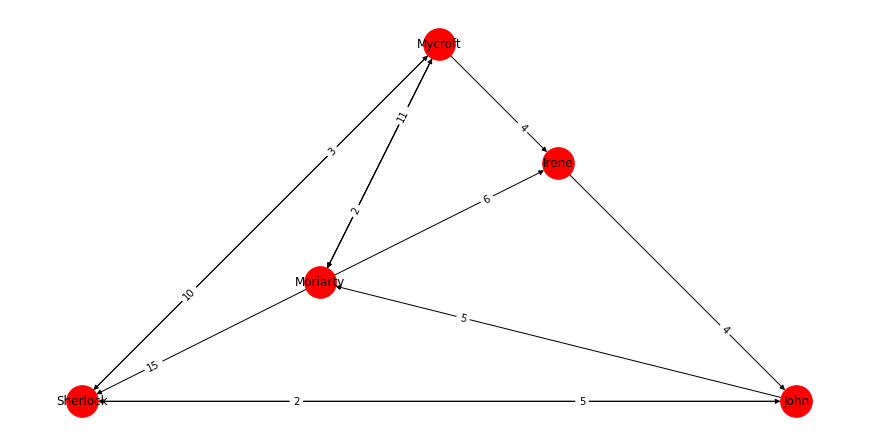

In [69]:
# Plot the debts as a graph
G = nx.MultiDiGraph()
G.add_nodes_from(MEMBERS)
G.add_weighted_edges_from(DEBTS)

plot_graph(G)



## Computer balance

Next, let’s compute everybody’s balance. The balance is the net amount of money someone must receive from all other members of the group (it can be negative if the person is a net debtor).

Any set of transactions we come up with must preserve everybody’s balance. In fact, a set of transaction is correct if and only if it does so: everybody must pay or receive as much money as they owed or were owed initially, and this is the only constraint on the solution we must pick.

In [72]:
def compute_balance(debts, members):
    balance = {member: 0 for member in members}

    return functools.reduce(
        lambda balance, debt: {
            **balance,
            debt[0]: balance[debt[0]] - debt[2],  # Removes the amount from the person who owes
            debt[1]: balance[debt[1]] + debt[2],  # Adds the amount to the person who is owed
        },
        debts,
        balance,
    )


In [73]:
compute_balance(DEBTS, MEMBERS)


{'Sherlock': 19, 'John': 2, 'Mycroft': -8, 'Irene': 6, 'Moriarty': -19}

In [74]:
# Check that the net balance is zero
assert sum(compute_balance(DEBTS, MEMBERS).values()) == 0


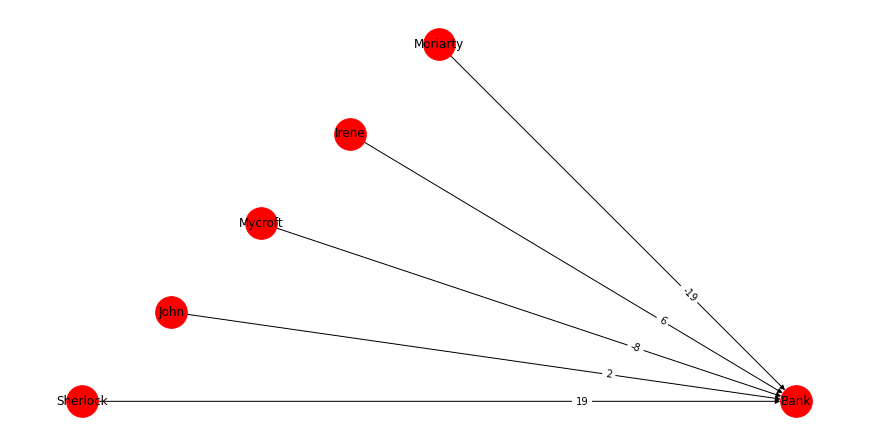

In [75]:
# Plot the balance as a graph

G = nx.DiGraph()
G.add_nodes_from(MEMBERS)
G.add_weighted_edges_from(
    [
        (member, "Bank", balance)
        for member, balance in compute_balance(DEBTS, MEMBERS).items()
    ]
)

plot_graph(G)


### Collector algorithm

Once we have balances, we can pick someone at random who we’ll call the collector (let’s take Sherlock as an example). Everybody with a negative balance will pay Grace for their total debt amount (to everybody in the group, not just Sherlock), and Sherlock will pay everybody with a positive balance for their total credit amount. We don’t include any other transactions in our solution set.

In [76]:
def simplify_with_collector(balances):
    # Arbitrarily pick the first member as the collector
    collector = next(iter(balances.keys()))
    
    return [
        (collector, person, balance)
        for (person, balance) in balances.items()
        if person != collector
    ]


In [77]:
simplify_with_collector(compute_balance(DEBTS, MEMBERS))


[('Sherlock', 'John', 2),
 ('Sherlock', 'Mycroft', -8),
 ('Sherlock', 'Irene', 6),
 ('Sherlock', 'Moriarty', -19)]

In [78]:
def show_transactions(transactions):
    for (debtor, creditor, value) in transactions:
        if value > 0:
            print(f"{debtor} owes {creditor} ${value}")
        else:
            print(f"{creditor} owes {debtor} ${-value}")

In [79]:
transactions = simplify_with_collector(compute_balance(DEBTS, MEMBERS))
show_transactions(transactions)


Sherlock owes John $2
Mycroft owes Sherlock $8
Sherlock owes Irene $6
Moriarty owes Sherlock $19


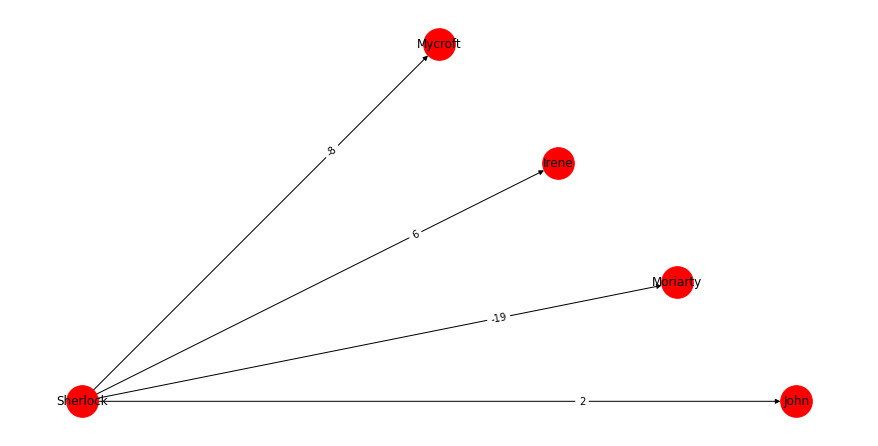

In [80]:
G = nx.DiGraph()
G.add_nodes_from(MEMBERS)
G.add_weighted_edges_from(transactions)

plot_graph(G)

This solution’s complexity is `O(m + n)` where m is the number of initial debts we consider, and n is the number of people; the only real work is to go over the m debts and compute balances, then add n transactions.

In practice, this solution is pretty good: it’s fast to compute, and each person except the collector has at most 1 transaction to make. On the other hand, the collector is part of `n −1` transactions, which can be a lot.

## Subgraphs - Subset sum problem

Any graph with n points and less than `n − 1` edges can’t be connected, so if there are less than `n − 1` transactions, there must be at least two separate components to the graph in our optimal solution. Equivalently, there must be two subgroups of people who can fully settle their debts internally. 

In [ ]:
import itertools

def find_zero_subset(balances):
    for i in range(1, len(balances)):
        for subset in itertools.combinations(balances.items(), i):
            if sum([balance[1] for balance in subset]) == 0:
                return [balance[0] for balance in subset]
    return None

def find_subsets(balances):
    subsets = []
    while (subset := find_zero_subset(balances)) is not None:
        subsets.append(subset)
        balances = {x[0]: x[1] for x in balances.items() if x[0] not in subset}
    subsets.append(list(balances.keys()))
    return subsets

def find_optimal_subset(subsets, balances):
    optimal_transactions = []
    for subset in subsets:
        subset_balances = {person: balances[person] for person in subset}
        optimal_transactions.extend(simplify_with_collector(subset_balances))
    return optimal_transactions

def simplify_with_optimal_subset(balances):
    subsets = find_subsets(balances)
    return find_optimal_subset(subsets, balances)


transactions = simplify_with_optimal_subset(compute_balance(DEBTS, MEMBERS))
show_transactions(transactions)

## Plotting the subgraphs

In [ ]:
SG = nx.DiGraph()
SG.add_nodes_from(MEMBERS)
SG.add_weighted_edges_from(transactions)
plot_graph(reorient_digraph(SG))